In [1]:
import pandas as pd
import os
from IPython.display import Image

# Data Pipeline for Test Data

For creating our test data, we used the Linux command `zcat` to extract 20 lines each from 24 of our raw fastq files. We chose 24 because our files are paired-end, meaning that the 24 files correspond to 12 samples. The 12 samples then correspond to the 3 brain regions we are focused on (AnCg, DLPFC, and the nAcc), with a schizophrenia group, bipolar disorder group, major depressive disorder group, and a control group for each (3 * 4 = 12, 12 * 2 = 24). So, we effectively chose one of each so that we could have a "pseudo-comparison" in our test analysis.

This was an example of the command we used to extract the test data from the `fastq.gz` raw genetic data files:

`zcat /datasets/srp073813/SRR3438555_1.fastq.gz | head -20 > SRR3438555_1_test.fq`

## FastQC

The first step in our pre-processing pipeline involves using `FastQC` on each `fastq` file for quality control. 

Sample `FastQC` output:

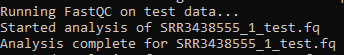

In [4]:
Image(filename="/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/images/fastqc_sample.PNG")

Each `FastQC` run outputs a `.zip` file with specific information on the run, as well as an overall report of the quality of the sample in an `.html` file. 

When running `FastQC`, we are looking for bad-quality reads, specifically the presence of any adapters that are added during the data preparation step (we did not do this because the data was already provided to us), as well as any erroneous sequences. Our pipeline looks through the outputs of the `FastQC` reports and checks if the data file passes the "Basic Summary" section of each report. If it did, then we reasoned that the data was of good quality.

The fact that the data all pass the quality checks suggests that the researchers who prepared the data probably already cleaned it before providing it to others for research. 

If there are low-quality reads or sequences, we would use the adapter cleaning tool, `cutadapt`, to remove the sub-standard reads. Since `FastQC` tells us that all the reads have no overrepresented sequences (aka adapters) and that all our reads passed the "pass/fail" check, we may not need to run `cutadapt` for these sample reads, because there is nothing extraneous to remove.

## Kallisto

After quality control of the data is finished, we need to perform alignment of each of the pairs to "combine" the information of the paired-end data. This allows us to quantify the expressions of the reads and receive counts of each gene for each sample (study subject). 

Sample `Kallisto` output:

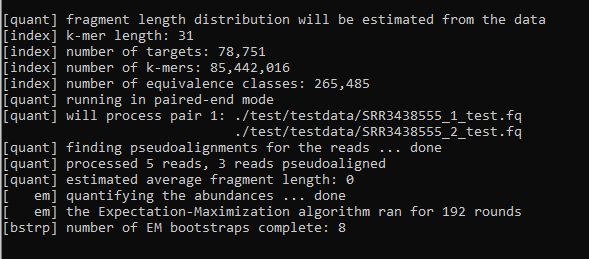

In [5]:
Image(filename = '/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/images/kallisto_sample.PNG')

To do the alignment, we decided to use the `Kallisto` tool. Using a reference genome generated by `Kallisto`, we perform alignment of the RNA samples to quantify gene expression. The reference genome tells us the genes that are found in our samples, but we do not need all the genes for analysis. For example, the reference genome includes genes that do not transcribe mRNA, which we are not interested in. The reference file also includes genes that are quantified on the X and Y chromosomes, which we also do not want, since those are different between gender. We do not wish to include the factor of gender because it could be a confounding variable that affects our final results.

In [16]:
pd.read_csv('/datasets/srp073813/reference/Gene_Naming.csv').head(1)

,chr,start,stop,refseq,refseq_accession,ensembl,ensembl_gene_id,hgnc_id,symbol,name,entrez_id,gene_type
0,chr1,69091,70008,NM_001005484.2,NM_001005484,ENSG00000186092.4,ENSG00000186092,HGNC:14825,OR4F5,olfactory receptor family 4 subfamily F member 5,79501,protein_coding


The dataset `Gene_Naming.csv` gave us the information for the genes in the human genome that transcribe mRNA and those that are quantified on the X and Y chromosomes. This information helped us filter out the genes we do not want, leaving about 17000 genes for our differential gene expression analysis.

After running Kallisto on each of the paired samples, we retrieved the counts of the ~17000 genes for each of the samples, as shown below.

In [15]:
pd.read_csv('/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/data/raw/gene_matrix.csv')

,0,SRR3438555,SRR3438556,SRR3438557,SRR3438558,SRR3438559,SRR3438560,SRR3438561,SRR3438562,SRR3438563,...,SRR3438897,SRR3438898,SRR3438899,SRR3438900,SRR3438901,SRR3438902,SRR3438903,SRR3438904,SRR3438905,SRR3438906
0,NM_000014.6,3747.5600,4490.170000,5012.8800,3809.9700,10871.9000,5759.500000,4137.6100,4502.830000,8302.290000,...,7973.800000,6894.670000,9889.4300,4426.520000,9033.130,6444.700000,7191.700,5149.850000,11567.90000,7119.4300
1,NM_000015.3,0.0000,8.000000,2.0000,2.0000,5.0000,5.000000,6.0000,5.000000,1.000000,...,3.000000,0.000000,3.0000,6.000000,6.000,2.000000,2.000,2.000000,11.00000,0.0000
2,NM_000016.6,392.9280,560.017000,407.6110,168.5430,949.0500,823.235000,711.4660,673.752000,654.908000,...,947.351000,675.333000,784.1540,637.190000,701.711,538.237000,508.883,86.369000,1199.54000,1127.3000
3,NM_000017.4,371.8200,284.504000,353.1230,233.9230,493.6150,419.835000,444.6540,443.921000,331.690000,...,372.887000,522.321000,560.1810,377.186000,560.794,574.304000,408.492,237.292000,886.15300,72.0545
4,NM_000018.4,4365.3100,3397.390000,3482.6100,2901.6000,5218.4200,4752.490000,4436.3800,3997.980000,5171.560000,...,3997.810000,4275.070000,3789.8600,2765.470000,3635.800,4502.080000,3337.070,1651.360000,8344.51000,1986.6100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17157,NM_213656.4,0.0000,1.000000,0.0000,0.0000,2.0000,1.000000,4.0000,3.000000,1.000000,...,4.000000,2.000000,0.0000,1.000000,3.000,2.000000,3.000,2.000000,4.00000,0.0000
17158,NM_213720.3,255.9300,346.896000,261.6250,294.1490,359.8120,343.186000,257.1920,249.621000,296.213000,...,484.941000,252.265000,361.8430,173.105000,185.901,122.463000,100.594,104.411000,473.32600,181.2790
17159,NM_213726.3,0.0000,0.000000,0.0000,0.0000,0.0000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000,0.000000,0.000,0.000000,6.88051,0.0000
17160,NM_214710.5,0.0000,0.006612,0.0000,0.0000,0.0000,0.009154,0.0000,0.011519,0.012507,...,0.006826,0.007598,0.0000,0.010516,0.000,0.007206,0.000,0.037059,0.00000,0.0000


Before moving on to the next step, we have to perform a "split-up" step of our data. The gene matrix consists of all the samples in our study in its entirety. However, we want to compare different disorders with their respective control groups, and we also want to do the individual comparisons within each brain region. This means doing 9 comparisons, so we need to "split" the gene matrix into 9 sections. We did this using the dataset below, the SRA Run Table, provided to us by the researchers in our replication paper.

In [14]:
pd.read_csv('/datasets/srp073813/reference/SraRunTable.csv').head(1)

,Run,age_at_death,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Brain_pH,brain_region,Bytes,...,LibrarySelection,LibrarySource,Organism,Platform,post-mortem_interval,ReleaseDate,Sample Name,source_name,SRA Study,TISSUE
0,SRR3438555,40,RNA-Seq,100,4177603300,PRJNA319583,SAMN04901133,6.76,AnCg,2585349730,...,cDNA,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,12.25,2017-06-25T00:00:00Z,GSM2132201,AnCg_Control,SRP073813,brain


The SRA Run Table provides us with the information about each of the sample runs, including what region the sample was extracted from, the disorder the individual was afflicted with, the age (at death) of the individual, brain pH, and post-mortem interval (amount of time after death that the sample was collected). These variables are needed as part of the model that DESeq2 uses for computing differential gene expression. We also need this information for each of the 9 comparisons, so that DESeq2 knows what samples were in the "affected" (disorder) group and which samples were control when it does the comparisons.

## DESeq2

The R-based tool, DeSEQ2, performs gene differential expression analysis on the output of the alignment. The tool normalizes the alignment counts, and then makes comparisons of the counts between each disorder group and control group in each of the brain regions. Specifically, it computes a log fold change value that measures the difference. Then, it calculates a p-value based on a hypothesis test that determines whether or not there was a statistically significant difference in gene expression between the disorder and control groups.

Because of the absence of DESeq2 on DSMLP and trouble with incorporating it in our docker, as well as issues of DESeq2 not working well with small datasets (like our test data), we could not incorporate DESeq2 into our test data pipeline in time.

So, here are the figures that we created locally for **ALL** of our data.

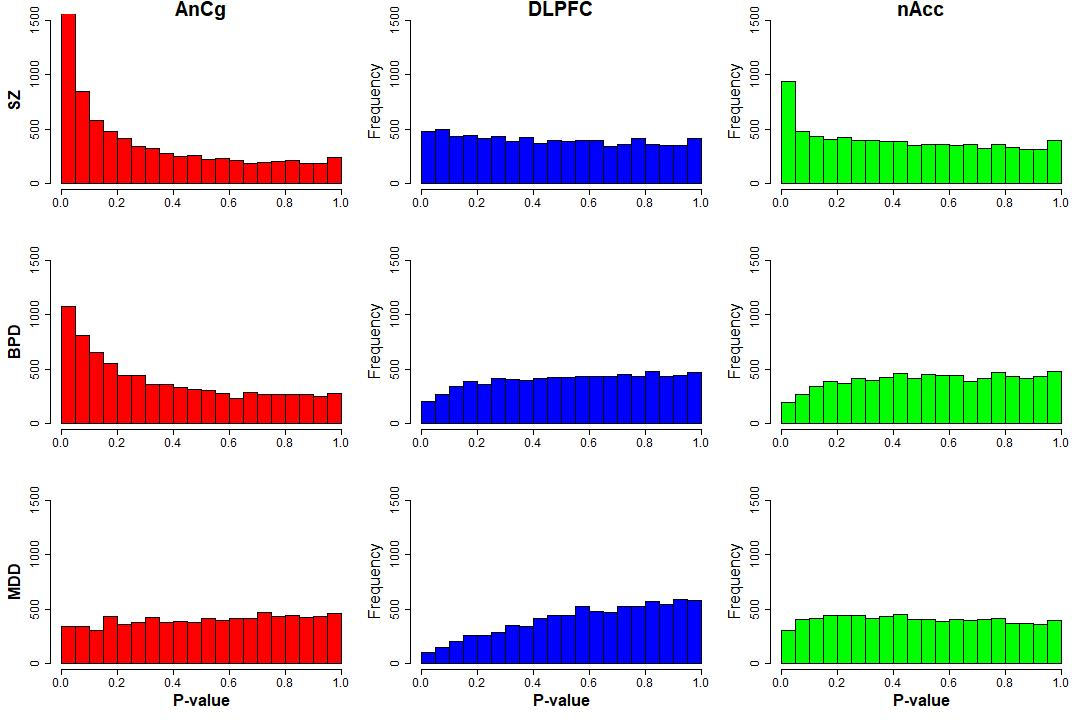

In [18]:
Image(filename = '/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/images/histplot.jpg')

From the histograms above, we can see there is a large amount of statistically significant p-values (<0.05) in the AnCg region for both SZ & BPD versus control and in the nAcc region for SZ versus control groups. This means that these groups contained genes that were differentially expressed compared to the CTL groups whereas the DLPFC region did not have as much genes expressed differently from the CTL.

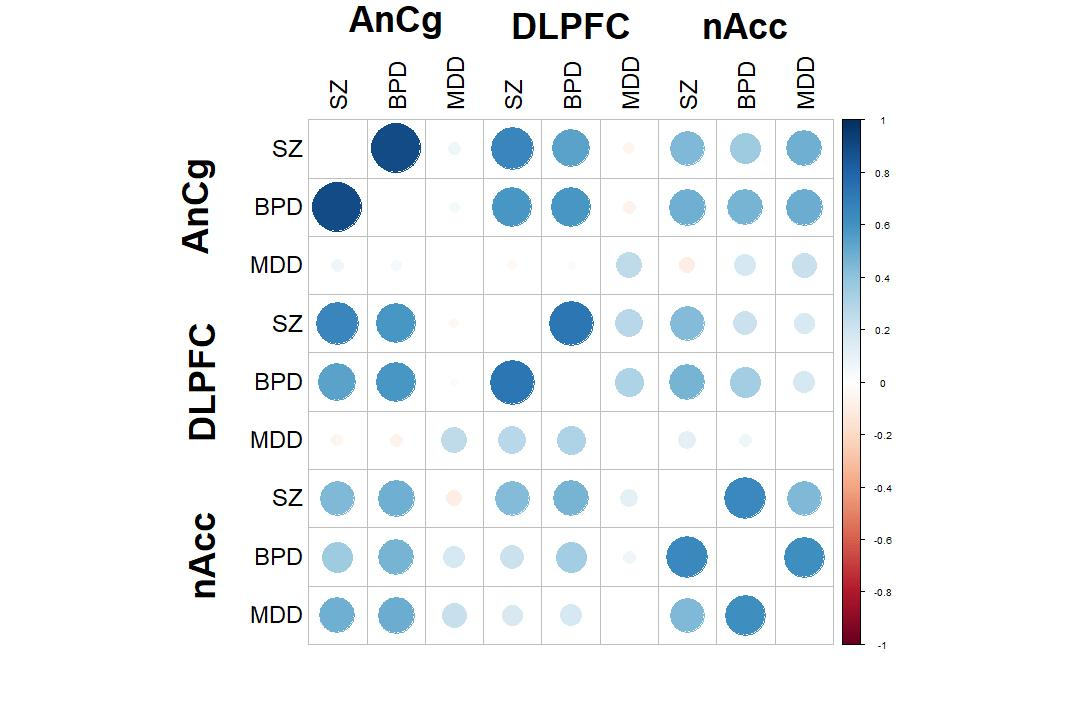

In [19]:
Image(filename = '/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/images/corrplot.jpg')

The diagram above portrays the pairwise Spearman correlation of the log fold changes between each disorder and control group in each region of the brain. The color and shape of the circles reflect the Spearman correlation values. As we can see, SZ and BPD display similar gene expression patterns.

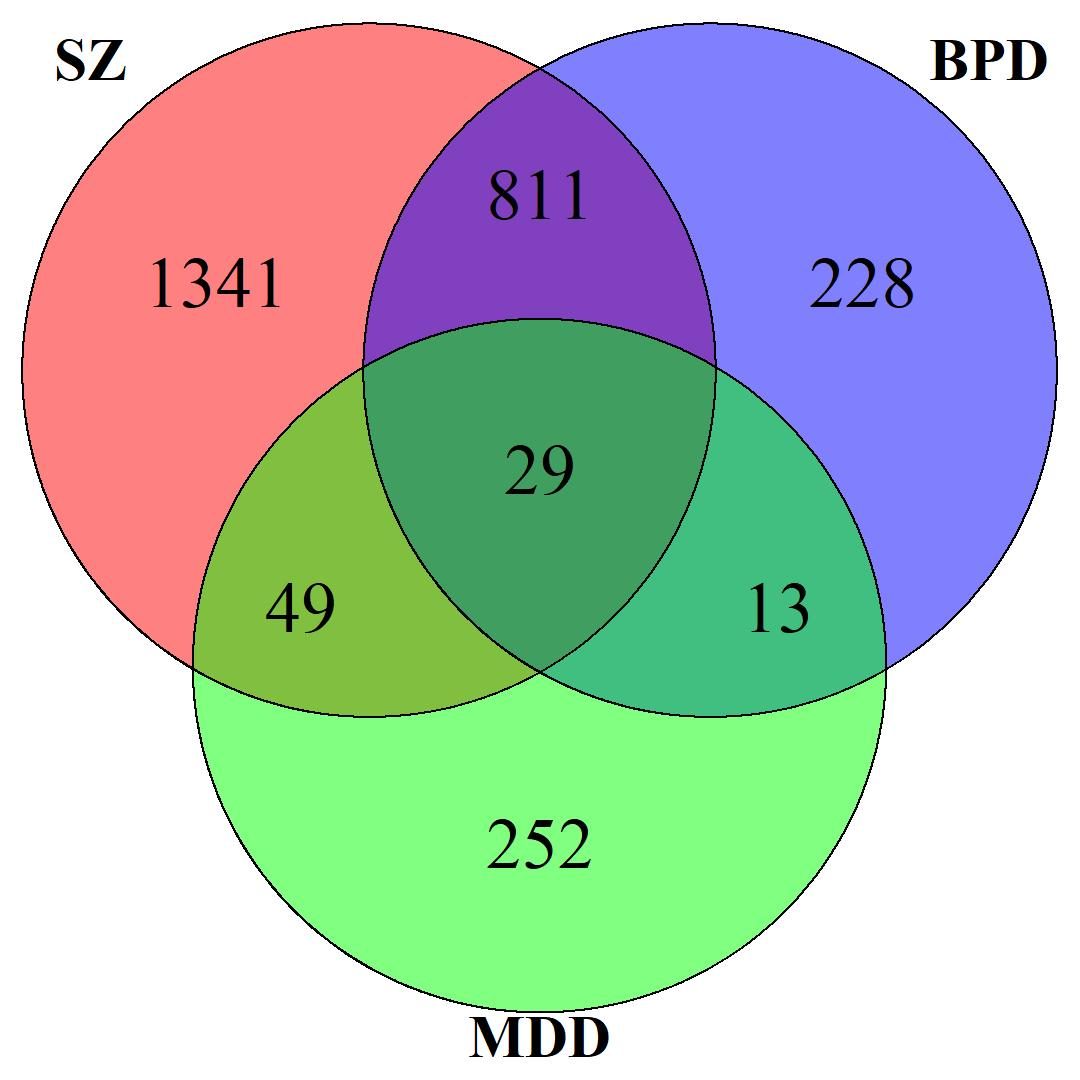

In [20]:
Image(filename = '/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/images/vennDiagram.jpg')

The Venn diagram above shows the number of overlapping genes that were differentially expressed in the AnCg brain tissue between the disorders where schizophrenia represents red, depression represents green, and bipolar as blue. It is shown that SZ and BPD is the only group to show considerable genes expressed overlapping in the AnCg.

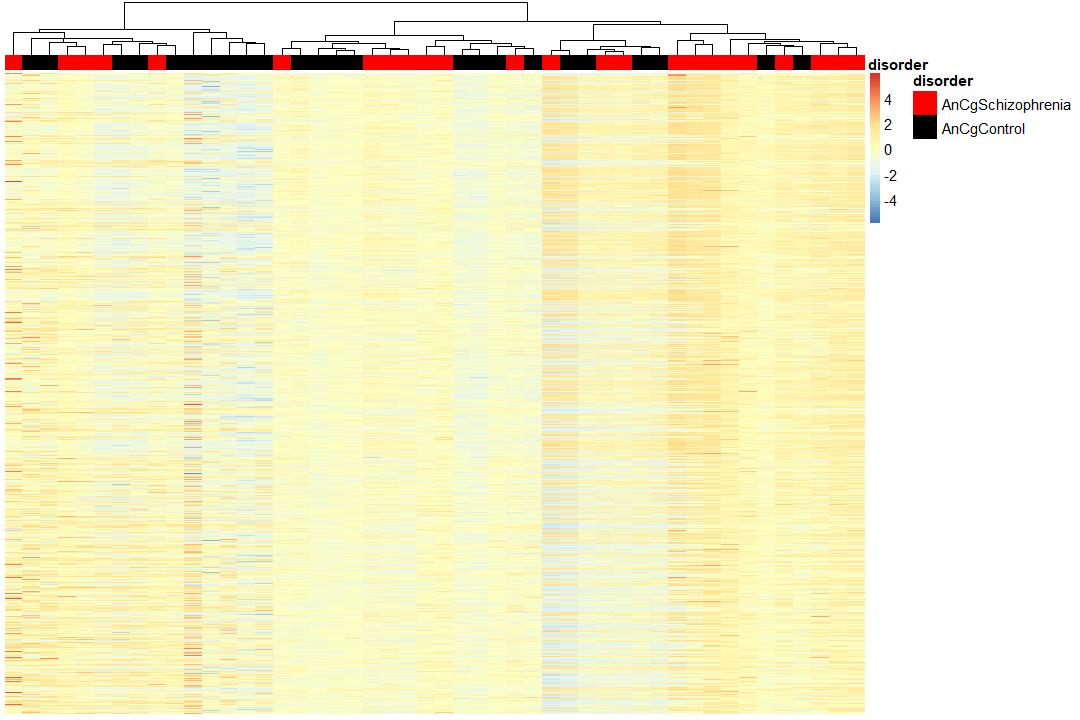

In [21]:
Image(filename = '/datasets/home/home-01/33/333/jll020/dsc180a-b04-group04/images/heatMap.jpg')

The above shows a heatmap using hierarchical clustering of both SZ and CTL in the AnCg region using variance-stablized expression of 8000 genes differentially expressed. The blue pixels represent genes that were lowly expressed whereas the yellow pixels represent genes that were highly expressed.